In [1]:
# python pred.py pred -c pred.yaml \
# --ckpt_path=train/reborn-v1-ckpt/ckpt-step=632000-val_loss=0.24.ckpt \
# --data.dataset_path=data/50palm.fa \
# --data.preprocess_to=data/50palm \
# --trainer.default_root_dir=train/50palm
import torch
import pickle as pkl
import pandas as pd
import numpy as np
from typing import Dict,Union
from reseek2 import cal_mu_v2


/home/mutest1/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns
# import matplotlib.pyplot as plt

xkcd_color=lambda x:mcolors.to_rgb(mcolors.XKCD_COLORS[f'xkcd:{x}'])
def configure_rcParams():
    c_rcParams=plt.rcParamsDefault
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update({
        # "text.usetex": True,
        # "text.latex.preamble": r"\usepackage{amsmath}",
        'svg.fonttype':'none',
        'font.sans-serif':['Arial','Helvetica',
            'DejaVu Sans',
            'Bitstream Vera Sans',
            'Computer Modern Sans Serif',
            'Lucida Grande',
            'Verdana',
            'Geneva',
            'Lucid',
            'Avant Garde',
            'sans-serif'],
        "pdf.use14corefonts":False,
        'pdf.fonttype':42,
        'text.color':xkcd_color('dark grey'),
        'axes.labelweight':'heavy',
        'axes.titleweight':'extra bold',
        'figure.facecolor':'none',
        'savefig.transparent':True
            })
    return c_rcParams
configure_rcParams()

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'both',
   

In [3]:
#
raw_opt:dict=torch.load('train/50palm/test_output/raw_output.pt')
#
# label_maps:dict=pkl.load(open('label_maps.pkl','rb'))
label_maps=raw_opt.pop('#label_maps',None)
if label_maps is None:
    label_maps=pkl.load(open('data/AF_SWISS_mufactorized_debug/label_maps.pkl','rb'))
label_maps_r={k:{v_:k_ for k_,v_ in v.items()} for k,v in label_maps.items()}


In [4]:

#
mu_map=pd.read_csv('train/v2-test/deliver-pack/mu_map.tsv',sep=r'\s+')
mu_map_dict={}
heads=['SS3','NbrSS3','RevNbrDist4']
for _,i in mu_map.iterrows():
    mu_map_dict[tuple(i[heads])]=i['Mu']
mu_map_dict_r={v:k for k,v in mu_map_dict.items()}

#
# scop40_mu:pd.DataFrame=pd.read_pickle('scop40_mu.pkl')

In [5]:
def convert_raw_opt(item:Dict[str,Union[str,torch.Tensor]]):
    ret={'stem':item['stem'],'seq':item['seq']}
    for head in ['Conf3','NENConf3','RevNbrDist4']:
        _=torch.max(item[head],dim=-1)
        ret[f'{head}-pred'],ret[f'{head}-conf']=  ''.join([label_maps_r[head][i]  for i in _.indices.tolist()]),_.values.tolist()
        if head =='NENConf3':
            tmp_map=lambda i,j: label_maps_r[head][i] if j>0.7 else 'C'
            ret[f'{head}-mask-pred']=''.join([tmp_map(i,j) for i,j in zip(_.indices.tolist(),_.values.tolist()) ])
    ret['mu-pred']=''.join([mu_map_dict[i] for i in zip(*[ret[f'{i}-pred'] for i in ['Conf3','NENConf3','RevNbrDist4']])])
    ret['mu-mask-pred']=''.join([mu_map_dict[i] for i in zip(*[ret[f'{i}-pred'] for i in ['Conf3','NENConf3-mask','RevNbrDist4']])])
    ret['mu-conf']=np.prod(np.array([ret[f'{i}-conf'] for i in ['Conf3','NENConf3','RevNbrDist4']]),axis=0)
    return ret
pcs_opt=[]
for i in raw_opt.values():
    pcs_opt.append(convert_raw_opt(i))

In [13]:
pcs_opt_df.columns

Index(['stem', 'seq', 'Conf3-pred', 'Conf3-conf', 'NENConf3-pred',
       'NENConf3-conf', 'NENConf3-mask-pred', 'RevNbrDist4-pred',
       'RevNbrDist4-conf', 'mu-pred', 'mu-mask-pred', 'mu-conf'],
      dtype='object')

In [6]:
pcs_opt_df=pd.DataFrame(pcs_opt)
pcs_opt_df['length']=pcs_opt_df['seq'].apply(lambda x:len(x))
for i,head in enumerate(['Conf3','NENConf3','RevNbrDist4','mu']):
    pcs_opt_df[f'{head}-conf-avg']=pcs_opt_df[f'{head}-conf'].apply(lambda x:sum(x)/len(x))
from glob import glob
o=[]
for i in glob('train/50palm/folds/*.pdb'):
    o.append(cal_mu_v2(i,'./reseek2',['Conf3','NENConf3','RENDist4']))
def to_mu(s:pd.Series):
    return ''.join([mu_map_dict[i] for i in zip(*[s[f'{i}'] for i in ['Conf3','NENConf3','RevNbrDist4']])])
pcs_opt_df=pd.merge(pcs_opt_df,pd.DataFrame(o).drop('seq',axis=1),on='stem')
pcs_opt_df.columns=['stem', 'seq', 'Conf3-pred', 'Conf3-conf', 'NENConf3-pred',
       'NENConf3-conf', 'NENConf3-mask-pred', 'RevNbrDist4-pred',
       'RevNbrDist4-conf', 'mu-pred', 'mu-mask-pred', 'mu-conf', 'length',
       'Conf3-conf-avg', 'NENConf3-conf-avg', 'RevNbrDist4-conf-avg',
       'mu-conf-avg', 'pLDDT', 'Conf3', 'NENConf3', 'RevNbrDist4']
pcs_opt_df['mu']=pcs_opt_df.apply(to_mu,axis=1)
pcs_opt_df['pLDDT_avg']=pcs_opt_df['pLDDT'].apply(lambda x:sum(x)/len(x))
# pcs_opt_df['pLDDT_avg']=pcs_opt_df['pLDDT'].apply(lambda x:sum(x)/len(x))
from functools import partial
def cal_acc(s:pd.Series,k:str='Conf3'):
    _=[i==j for i,j in zip(s[f'{k}-pred'],s[k])]
    return sum(_)/len(_)
for head in ['Conf3','NENConf3','RevNbrDist4','mu']:
    pcs_opt_df[f'{head}-acc']=pcs_opt_df.apply(partial(cal_acc,k=head),axis=1)
pcs_opt_df=pcs_opt_df[[
    'stem', 'seq', 'length', 'pLDDT','pLDDT_avg',
    'Conf3','Conf3-pred', 'Conf3-conf','Conf3-conf-avg','Conf3-acc',
    'NENConf3', 'NENConf3-pred', 'NENConf3-conf', 'NENConf3-conf-avg','NENConf3-acc',
    'RevNbrDist4','RevNbrDist4-pred','RevNbrDist4-conf', 'RevNbrDist4-conf-avg','RevNbrDist4-acc',
    'mu','mu-pred', 'mu-conf', 'mu-conf-avg','mu-acc',
    'NENConf3-mask-pred','mu-mask-pred', 
       ]]

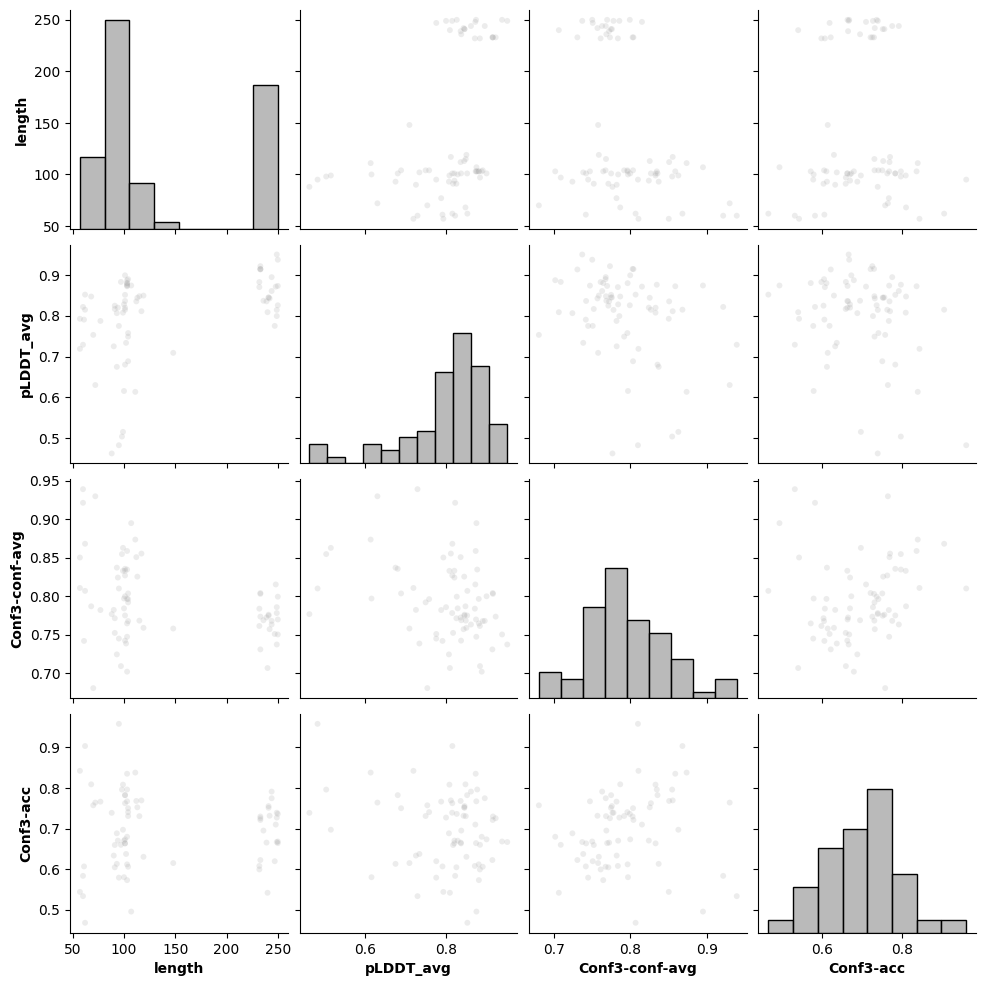

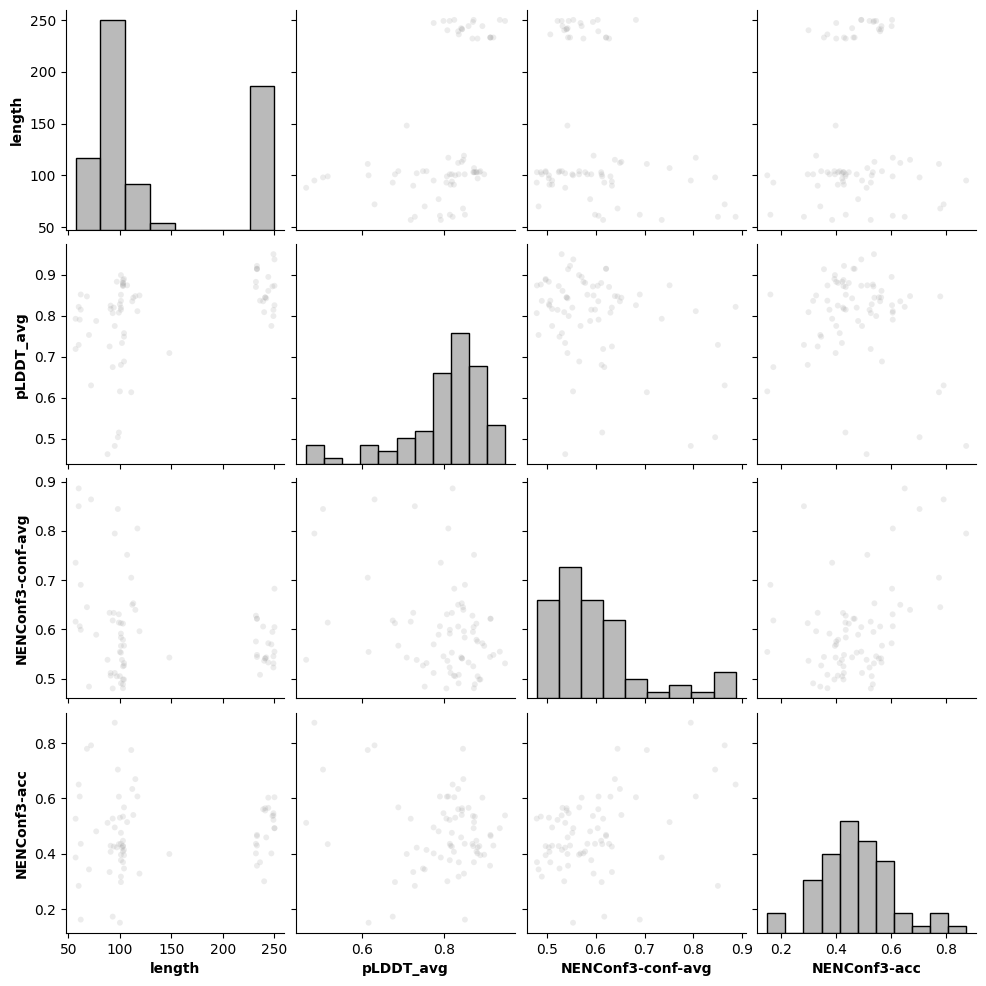

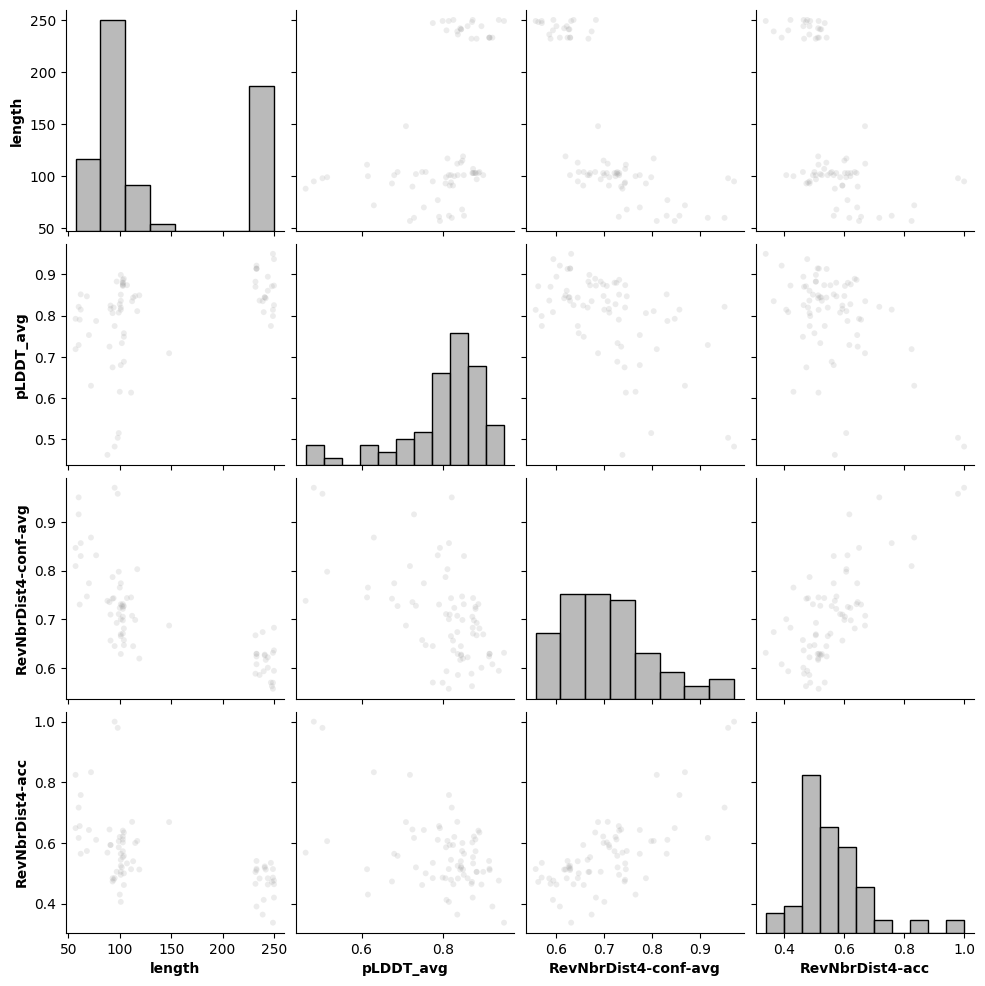

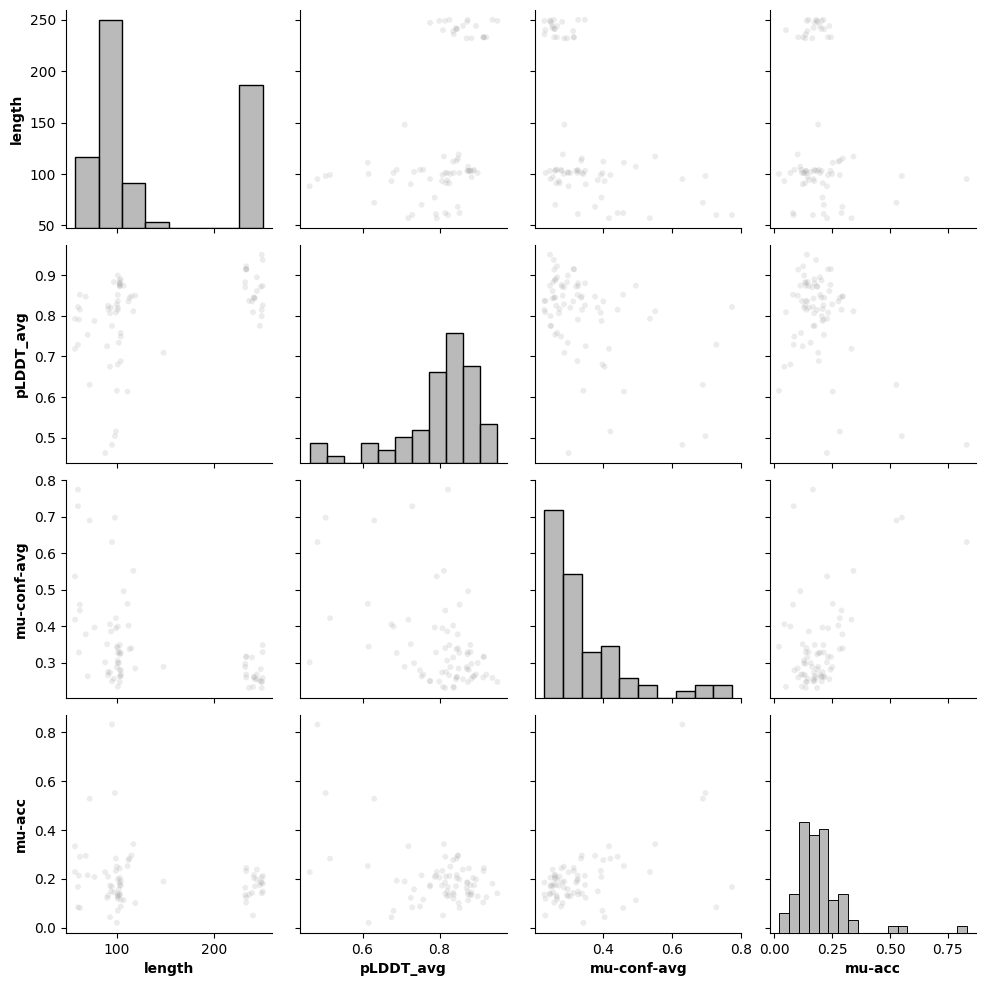

In [47]:
for head in ['Conf3','NENConf3','RevNbrDist4','mu']:
    sns.pairplot(pcs_opt_df[['length','pLDDT_avg',f'{head}-conf-avg',f'{head}-acc']],
                 plot_kws=dict(linewidth=0,alpha=0.2,size=0.5,color='#a3a3a3'),diag_kws=dict(color='#a3a3a3'))
    plt.savefig(f'train/50palm/test_output/accana-{head}.svg')
    plt.show()
    plt.close()

In [11]:
pcs_opt_df

In [5]:
o

[{'stem': 'u150689',
  'seq': 'TDVDQKSWDLVARYFATCPVLMPKGEIFVKRTRGIPSGSWFTQLIGSMCNQFLVEYLSVLSGDGIVDGVYLGDDSVI',
  'pLDDT': [0.55,
   0.7,
   0.76,
   0.81,
   0.83,
   0.85,
   0.82,
   0.8,
   0.82,
   0.8,
   0.77,
   0.77,
   0.77,
   0.74,
   0.72,
   0.71,
   0.71,
   0.69,
   0.71,
   0.73,
   0.75,
   0.77,
   0.79,
   0.8,
   0.76,
   0.8,
   0.77,
   0.74,
   0.68,
   0.62,
   0.61,
   0.6,
   0.65,
   0.68,
   0.7,
   0.69,
   0.7,
   0.69,
   0.71,
   0.67,
   0.74,
   0.8,
   0.82,
   0.8,
   0.8,
   0.83,
   0.87,
   0.84,
   0.85,
   0.88,
   0.89,
   0.88,
   0.89,
   0.9,
   0.89,
   0.89,
   0.88,
   0.89,
   0.87,
   0.89,
   0.87,
   0.85,
   0.82,
   0.81,
   0.79,
   0.8,
   0.81,
   0.85,
   0.87,
   0.88,
   0.87,
   0.83,
   0.83,
   0.86,
   0.86,
   0.86,
   0.82],
  'Conf3': 'CCCCCAAAAAAAAAAACCBBBCCACCBBCCCCCCBBCCCCAAAAAAAAAAAAAAAAAAAACCCCCBBBBBCCCCBCC',
  'NENConf3': 'AAAAAAAAAAAACABCCBBBBBCCCCAAACCAAAABBBCAACCCCCCBCCBCCBBCCCCCCCCCAAAAAAAAAAAAA',
  'RENDist4'

In [7]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from typing import List
import seaborn as sns


In [7]:


fig,axes=plt.subplots(4,1,sharex=True,figsize=(5,12))
axes:List[Axes]
for i,head in enumerate(['Conf3','NENConf3','RevNbrDist4','mu']):
    _=[]
    for c in pcs_opt_df[f'{head}-conf']:
        _.extend(c)
    axes[i].hist(_)
    axes[i].set_xlabel(f'{head}-conf')

fig.tight_layout()
fig.savefig('train/50palm/test_output/conf-dist-res.png')
plt.close(fig)
fig.tight_layout()
fig.savefig('train/50palm/test_output/conf-dist-res.png')
plt.close(fig)


fig,axes=plt.subplots(4,1,sharex=True,figsize=(5,12))
axes:List[Axes]
for i,head in enumerate(['Conf3','NENConf3','RevNbrDist4','mu']):
    _=[]
    for c in pcs_opt_df[f'{head}-conf']:
        _.append(sum(c)/len(c))
    axes[i].hist(_)
    axes[i].set_xlabel(f'{head}-conf')
fig.tight_layout()
fig.savefig('train/50palm/test_output/conf-dist-seq.png')
plt.close(fig)


plt.hist(pcs_opt_df['length'])
plt.xlabel('seq_length')
plt.savefig('train/50palm/test_output/seqlength-dist.png')
plt.close()

sns.pairplot(pcs_opt_df[['length']+[f'{head}-conf-avg' for head in ['Conf3','NENConf3','RevNbrDist4']]],plot_kws=dict(marker="x", alpha=0.7,size=3))
plt.savefig('train/50palm/test_output/pairplot.png')
plt.close()


In [8]:
ScoreMx_Combo = [
  [  3.03, -0.75,  1.02,  0.83, -2.95, -1.19,  1.65, -2.12, -0.36,  1.19, -2.59, -0.83, -1.02, -4.80, -3.03, -0.19, -3.97, -2.21,  0.18, -3.60, -1.84, -2.03, -5.81, -4.04, -1.20, -4.98, -3.22, -0.82, -4.60, -2.83, -3.02, -6.80, -5.04, -2.20, -5.98, -4.21,  ], # 0
  [ -0.75,  3.58,  1.57, -2.95,  1.38, -0.64, -2.12,  2.21,  0.19, -2.59,  1.74, -0.28, -4.80, -0.47, -2.48, -3.97,  0.36, -1.66, -3.60,  0.73, -1.29, -5.81, -1.48, -3.49, -4.98, -0.65, -2.67, -4.60, -0.27, -2.28, -6.80, -2.47, -4.49, -5.98, -1.64, -3.66,  ], # 1
  [  1.02,  1.57,  2.59, -1.19, -0.64,  0.39, -0.36,  0.19,  1.21, -0.83, -0.28,  0.75, -3.03, -2.48, -1.46, -2.21, -1.66, -0.63, -1.84, -1.29, -0.26, -4.04, -3.49, -2.47, -3.22, -2.67, -1.64, -2.83, -2.28, -1.26, -5.04, -4.49, -3.46, -4.21, -3.66, -2.64,  ], # 2
  [  0.83, -2.95, -1.19,  3.35, -0.43,  1.33,  1.97, -1.81, -0.05, -1.02, -4.80, -3.03,  1.50, -2.28, -0.51,  0.12, -3.66, -1.89, -2.03, -5.81, -4.04,  0.49, -3.29, -1.52, -0.89, -4.67, -2.90, -3.02, -6.80, -5.04, -0.50, -4.28, -2.52, -1.88, -5.66, -3.90,  ], # 3
  [ -2.95,  1.38, -0.64, -0.43,  3.90,  1.88, -1.81,  2.52,  0.50, -4.80, -0.47, -2.48, -2.28,  2.06,  0.04, -3.66,  0.67, -1.34, -5.81, -1.48, -3.49, -3.29,  1.04, -0.97, -4.67, -0.34, -2.35, -6.80, -2.47, -4.49, -4.28,  0.05, -1.97, -5.66, -1.33, -3.35,  ], # 4
  [ -1.19, -0.64,  0.39,  1.33,  1.88,  2.91, -0.05,  0.50,  1.53, -3.03, -2.48, -1.46, -0.51,  0.04,  1.06, -1.89, -1.34, -0.32, -4.04, -3.49, -2.47, -1.52, -0.97,  0.05, -2.90, -2.35, -1.33, -5.04, -4.49, -3.46, -2.52, -1.97, -0.94, -3.90, -3.35, -2.32,  ], # 5
  [  1.65, -2.12, -0.36,  1.97, -1.81, -0.05,  2.70, -1.08,  0.69, -0.19, -3.97, -2.21,  0.12, -3.66, -1.89,  0.86, -2.92, -1.16, -1.20, -4.98, -3.22, -0.89, -4.67, -2.90, -0.15, -3.93, -2.17, -2.20, -5.98, -4.21, -1.88, -5.66, -3.90, -1.15, -4.93, -3.16,  ], # 6
  [ -2.12,  2.21,  0.19, -1.81,  2.52,  0.50, -1.08,  3.25,  1.24, -3.97,  0.36, -1.66, -3.66,  0.67, -1.34, -2.92,  1.41, -0.61, -4.98, -0.65, -2.67, -4.67, -0.34, -2.35, -3.93,  0.40, -1.62, -5.98, -1.64, -3.66, -5.66, -1.33, -3.35, -4.93, -0.60, -2.61,  ], # 7
  [ -0.36,  0.19,  1.21, -0.05,  0.50,  1.53,  0.69,  1.24,  2.26, -2.21, -1.66, -0.63, -1.89, -1.34, -0.32, -1.16, -0.61,  0.42, -3.22, -2.67, -1.64, -2.90, -2.35, -1.33, -2.17, -1.62, -0.59, -4.21, -3.66, -2.64, -3.90, -3.35, -2.32, -3.16, -2.61, -1.59,  ], # 8
  [  1.19, -2.59, -0.83, -1.02, -4.80, -3.03, -0.19, -3.97, -2.21,  2.08, -1.69,  0.07, -0.12, -3.90, -2.13,  0.71, -3.07, -1.31,  1.17, -2.61, -0.85, -1.03, -4.81, -3.05, -0.21, -3.99, -2.23,  0.61, -3.17, -1.40, -1.59, -5.37, -3.61, -0.77, -4.54, -2.78,  ], # 9
  [ -2.59,  1.74, -0.28, -4.80, -0.47, -2.48, -3.97,  0.36, -1.66, -1.69,  2.64,  0.62, -3.90,  0.43, -1.58, -3.07,  1.26, -0.76, -2.61,  1.72, -0.30, -4.81, -0.48, -2.50, -3.99,  0.34, -1.67, -3.17,  1.16, -0.85, -5.37, -1.04, -3.05, -4.54, -0.21, -2.23,  ], # 10
  [ -0.83, -0.28,  0.75, -3.03, -2.48, -1.46, -2.21, -1.66, -0.63,  0.07,  0.62,  1.65, -2.13, -1.58, -0.56, -1.31, -0.76,  0.27, -0.85, -0.30,  0.73, -3.05, -2.50, -1.47, -2.23, -1.67, -0.65, -1.40, -0.85,  0.17, -3.61, -3.05, -2.03, -2.78, -2.23, -1.21,  ], # 11
  [ -1.02, -4.80, -3.03,  1.50, -2.28, -0.51,  0.12, -3.66, -1.89, -0.12, -3.90, -2.13,  2.40, -1.38,  0.39,  1.02, -2.76, -0.99, -1.03, -4.81, -3.05,  1.49, -2.29, -0.53,  0.10, -3.67, -1.91, -1.59, -5.37, -3.61,  0.93, -2.85, -1.09, -0.45, -4.23, -2.47,  ], # 12
  [ -4.80, -0.47, -2.48, -2.28,  2.06,  0.04, -3.66,  0.67, -1.34, -3.90,  0.43, -1.58, -1.38,  2.95,  0.94, -2.76,  1.57, -0.44, -4.81, -0.48, -2.50, -2.29,  2.04,  0.02, -3.67,  0.66, -1.36, -5.37, -1.04, -3.05, -2.85,  1.48, -0.53, -4.23,  0.10, -1.91,  ], # 13
  [ -3.03, -2.48, -1.46, -0.51,  0.04,  1.06, -1.89, -1.34, -0.32, -2.13, -1.58, -0.56,  0.39,  0.94,  1.96, -0.99, -0.44,  0.58, -3.05, -2.50, -1.47, -0.53,  0.02,  1.05, -1.91, -1.36, -0.34, -3.61, -3.05, -2.03, -1.09, -0.53,  0.49, -2.47, -1.91, -0.89,  ], # 14
  [ -0.19, -3.97, -2.21,  0.12, -3.66, -1.89,  0.86, -2.92, -1.16,  0.71, -3.07, -1.31,  1.02, -2.76, -0.99,  1.75, -2.02, -0.26, -0.21, -3.99, -2.23,  0.10, -3.67, -1.91,  0.84, -2.94, -1.18, -0.77, -4.54, -2.78, -0.45, -4.23, -2.47,  0.28, -3.50, -1.73,  ], # 15
  [ -3.97,  0.36, -1.66, -3.66,  0.67, -1.34, -2.92,  1.41, -0.61, -3.07,  1.26, -0.76, -2.76,  1.57, -0.44, -2.02,  2.31,  0.29, -3.99,  0.34, -1.67, -3.67,  0.66, -1.36, -2.94,  1.39, -0.63, -4.54, -0.21, -2.23, -4.23,  0.10, -1.91, -3.50,  0.83, -1.18,  ], # 16
  [ -2.21, -1.66, -0.63, -1.89, -1.34, -0.32, -1.16, -0.61,  0.42, -1.31, -0.76,  0.27, -0.99, -0.44,  0.58, -0.26,  0.29,  1.31, -2.23, -1.67, -0.65, -1.91, -1.36, -0.34, -1.18, -0.63,  0.40, -2.78, -2.23, -1.21, -2.47, -1.91, -0.89, -1.73, -1.18, -0.16,  ], # 17
  [  0.18, -3.60, -1.84, -2.03, -5.81, -4.04, -1.20, -4.98, -3.22,  1.17, -2.61, -0.85, -1.03, -4.81, -3.05, -0.21, -3.99, -2.23,  2.70, -1.08,  0.69,  0.50, -3.28, -1.52,  1.32, -2.46, -0.69,  1.30, -2.47, -0.71, -0.90, -4.68, -2.91, -0.07, -3.85, -2.09,  ], # 18
  [ -3.60,  0.73, -1.29, -5.81, -1.48, -3.49, -4.98, -0.65, -2.67, -2.61,  1.72, -0.30, -4.81, -0.48, -2.50, -3.99,  0.34, -1.67, -1.08,  3.25,  1.24, -3.28,  1.05, -0.97, -2.46,  1.87, -0.14, -2.47,  1.86, -0.16, -4.68, -0.35, -2.36, -3.85,  0.48, -1.54,  ], # 19
  [ -1.84, -1.29, -0.26, -4.04, -3.49, -2.47, -3.22, -2.67, -1.64, -0.85, -0.30,  0.73, -3.05, -2.50, -1.47, -2.23, -1.67, -0.65,  0.69,  1.24,  2.26, -1.52, -0.97,  0.06, -0.69, -0.14,  0.88, -0.71, -0.16,  0.86, -2.91, -2.36, -1.34, -2.09, -1.54, -0.51,  ], # 20
  [ -2.03, -5.81, -4.04,  0.49, -3.29, -1.52, -0.89, -4.67, -2.90, -1.03, -4.81, -3.05,  1.49, -2.29, -0.53,  0.10, -3.67, -1.91,  0.50, -3.28, -1.52,  3.02, -0.76,  1.00,  1.64, -2.14, -0.38, -0.90, -4.68, -2.91,  1.62, -2.16, -0.39,  0.24, -3.54, -1.77,  ], # 21
  [ -5.81, -1.48, -3.49, -3.29,  1.04, -0.97, -4.67, -0.34, -2.35, -4.81, -0.48, -2.50, -2.29,  2.04,  0.02, -3.67,  0.66, -1.36, -3.28,  1.05, -0.97, -0.76,  3.57,  1.55, -2.14,  2.19,  0.17, -4.68, -0.35, -2.36, -2.16,  2.17,  0.16, -3.54,  0.79, -1.22,  ], # 22
  [ -4.04, -3.49, -2.47, -1.52, -0.97,  0.05, -2.90, -2.35, -1.33, -3.05, -2.50, -1.47, -0.53,  0.02,  1.05, -1.91, -1.36, -0.34, -1.52, -0.97,  0.06,  1.00,  1.55,  2.58, -0.38,  0.17,  1.20, -2.91, -2.36, -1.34, -0.39,  0.16,  1.18, -1.77, -1.22, -0.20,  ], # 23
  [ -1.20, -4.98, -3.22, -0.89, -4.67, -2.90, -0.15, -3.93, -2.17, -0.21, -3.99, -2.23,  0.10, -3.67, -1.91,  0.84, -2.94, -1.18,  1.32, -2.46, -0.69,  1.64, -2.14, -0.38,  2.37, -1.41,  0.35, -0.07, -3.85, -2.09,  0.24, -3.54, -1.77,  0.97, -2.81, -1.04,  ], # 24
  [ -4.98, -0.65, -2.67, -4.67, -0.34, -2.35, -3.93,  0.40, -1.62, -3.99,  0.34, -1.67, -3.67,  0.66, -1.36, -2.94,  1.39, -0.63, -2.46,  1.87, -0.14, -2.14,  2.19,  0.17, -1.41,  2.92,  0.91, -3.85,  0.48, -1.54, -3.54,  0.79, -1.22, -2.81,  1.52, -0.49,  ], # 25
  [ -3.22, -2.67, -1.64, -2.90, -2.35, -1.33, -2.17, -1.62, -0.59, -2.23, -1.67, -0.65, -1.91, -1.36, -0.34, -1.18, -0.63,  0.40, -0.69, -0.14,  0.88, -0.38,  0.17,  1.20,  0.35,  0.91,  1.93, -2.09, -1.54, -0.51, -1.77, -1.22, -0.20, -1.04, -0.49,  0.53,  ], # 26
  [ -0.82, -4.60, -2.83, -3.02, -6.80, -5.04, -2.20, -5.98, -4.21,  0.61, -3.17, -1.40, -1.59, -5.37, -3.61, -0.77, -4.54, -2.78,  1.30, -2.47, -0.71, -0.90, -4.68, -2.91, -0.07, -3.85, -2.09,  2.57, -1.21,  0.55,  0.36, -3.42, -1.65,  1.19, -2.59, -0.83,  ], # 27
  [ -4.60, -0.27, -2.28, -6.80, -2.47, -4.49, -5.98, -1.64, -3.66, -3.17,  1.16, -0.85, -5.37, -1.04, -3.05, -4.54, -0.21, -2.23, -2.47,  1.86, -0.16, -4.68, -0.35, -2.36, -3.85,  0.48, -1.54, -1.21,  3.12,  1.10, -3.42,  0.91, -1.10, -2.59,  1.74, -0.28,  ], # 28
  [ -2.83, -2.28, -1.26, -5.04, -4.49, -3.46, -4.21, -3.66, -2.64, -1.40, -0.85,  0.17, -3.61, -3.05, -2.03, -2.78, -2.23, -1.21, -0.71, -0.16,  0.86, -2.91, -2.36, -1.34, -2.09, -1.54, -0.51,  0.55,  1.10,  2.13, -1.65, -1.10, -0.08, -0.83, -0.28,  0.75,  ], # 29
  [ -3.02, -6.80, -5.04, -0.50, -4.28, -2.52, -1.88, -5.66, -3.90, -1.59, -5.37, -3.61,  0.93, -2.85, -1.09, -0.45, -4.23, -2.47, -0.90, -4.68, -2.91,  1.62, -2.16, -0.39,  0.24, -3.54, -1.77,  0.36, -3.42, -1.65,  2.88, -0.90,  0.87,  1.50, -2.28, -0.51,  ], # 30
  [ -6.80, -2.47, -4.49, -4.28,  0.05, -1.97, -5.66, -1.33, -3.35, -5.37, -1.04, -3.05, -2.85,  1.48, -0.53, -4.23,  0.10, -1.91, -4.68, -0.35, -2.36, -2.16,  2.17,  0.16, -3.54,  0.79, -1.22, -3.42,  0.91, -1.10, -0.90,  3.44,  1.42, -2.28,  2.05,  0.04,  ], # 31
  [ -5.04, -4.49, -3.46, -2.52, -1.97, -0.94, -3.90, -3.35, -2.32, -3.61, -3.05, -2.03, -1.09, -0.53,  0.49, -2.47, -1.91, -0.89, -2.91, -2.36, -1.34, -0.39,  0.16,  1.18, -1.77, -1.22, -0.20, -1.65, -1.10, -0.08,  0.87,  1.42,  2.44, -0.51,  0.04,  1.06,  ], # 32
  [ -2.20, -5.98, -4.21, -1.88, -5.66, -3.90, -1.15, -4.93, -3.16, -0.77, -4.54, -2.78, -0.45, -4.23, -2.47,  0.28, -3.50, -1.73, -0.07, -3.85, -2.09,  0.24, -3.54, -1.77,  0.97, -2.81, -1.04,  1.19, -2.59, -0.83,  1.50, -2.28, -0.51,  2.24, -1.54,  0.22,  ], # 33
  [ -5.98, -1.64, -3.66, -5.66, -1.33, -3.35, -4.93, -0.60, -2.61, -4.54, -0.21, -2.23, -4.23,  0.10, -1.91, -3.50,  0.83, -1.18, -3.85,  0.48, -1.54, -3.54,  0.79, -1.22, -2.81,  1.52, -0.49, -2.59,  1.74, -0.28, -2.28,  2.05,  0.04, -1.54,  2.79,  0.77,  ], # 34
  [ -4.21, -3.66, -2.64, -3.90, -3.35, -2.32, -3.16, -2.61, -1.59, -2.78, -2.23, -1.21, -2.47, -1.91, -0.89, -1.73, -1.18, -0.16, -2.09, -1.54, -0.51, -1.77, -1.22, -0.20, -1.04, -0.49,  0.53, -0.83, -0.28,  0.75, -0.51,  0.04,  1.06,  0.22,  0.77,  1.80,  ], # 35
]

IntScoreMx_Combo = [
  [   3,  -1,   1,   1,  -3,  -1,   2,  -2,   0,   1,  -3,  -1,  -1,  -5,  -3,   0,  -4,  -2,   0,  -4,  -2,  -2,  -6,  -4,  -1,  -5,  -3,  -1,  -5,  -3,  -3,  -7,  -5,  -2,  -6,  -4,  ], # 0
  [  -1,   4,   2,  -3,   1,  -1,  -2,   2,   0,  -3,   2,   0,  -5,   0,  -2,  -4,   0,  -2,  -4,   1,  -1,  -6,  -1,  -3,  -5,  -1,  -3,  -5,   0,  -2,  -7,  -2,  -4,  -6,  -2,  -4,  ], # 1
  [   1,   2,   3,  -1,  -1,   0,   0,   0,   1,  -1,   0,   1,  -3,  -2,  -1,  -2,  -2,  -1,  -2,  -1,   0,  -4,  -3,  -2,  -3,  -3,  -2,  -3,  -2,  -1,  -5,  -4,  -3,  -4,  -4,  -3,  ], # 2
  [   1,  -3,  -1,   3,   0,   1,   2,  -2,   0,  -1,  -5,  -3,   2,  -2,  -1,   0,  -4,  -2,  -2,  -6,  -4,   0,  -3,  -2,  -1,  -5,  -3,  -3,  -7,  -5,  -1,  -4,  -3,  -2,  -6,  -4,  ], # 3
  [  -3,   1,  -1,   0,   4,   2,  -2,   3,   1,  -5,   0,  -2,  -2,   2,   0,  -4,   1,  -1,  -6,  -1,  -3,  -3,   1,  -1,  -5,   0,  -2,  -7,  -2,  -4,  -4,   0,  -2,  -6,  -1,  -3,  ], # 4
  [  -1,  -1,   0,   1,   2,   3,   0,   1,   2,  -3,  -2,  -1,  -1,   0,   1,  -2,  -1,   0,  -4,  -3,  -2,  -2,  -1,   0,  -3,  -2,  -1,  -5,  -4,  -3,  -3,  -2,  -1,  -4,  -3,  -2,  ], # 5
  [   2,  -2,   0,   2,  -2,   0,   3,  -1,   1,   0,  -4,  -2,   0,  -4,  -2,   1,  -3,  -1,  -1,  -5,  -3,  -1,  -5,  -3,   0,  -4,  -2,  -2,  -6,  -4,  -2,  -6,  -4,  -1,  -5,  -3,  ], # 6
  [  -2,   2,   0,  -2,   3,   1,  -1,   3,   1,  -4,   0,  -2,  -4,   1,  -1,  -3,   1,  -1,  -5,  -1,  -3,  -5,   0,  -2,  -4,   0,  -2,  -6,  -2,  -4,  -6,  -1,  -3,  -5,  -1,  -3,  ], # 7
  [   0,   0,   1,   0,   1,   2,   1,   1,   2,  -2,  -2,  -1,  -2,  -1,   0,  -1,  -1,   0,  -3,  -3,  -2,  -3,  -2,  -1,  -2,  -2,  -1,  -4,  -4,  -3,  -4,  -3,  -2,  -3,  -3,  -2,  ], # 8
  [   1,  -3,  -1,  -1,  -5,  -3,   0,  -4,  -2,   2,  -2,   0,   0,  -4,  -2,   1,  -3,  -1,   1,  -3,  -1,  -1,  -5,  -3,   0,  -4,  -2,   1,  -3,  -1,  -2,  -5,  -4,  -1,  -5,  -3,  ], # 9
  [  -3,   2,   0,  -5,   0,  -2,  -4,   0,  -2,  -2,   3,   1,  -4,   0,  -2,  -3,   1,  -1,  -3,   2,   0,  -5,   0,  -2,  -4,   0,  -2,  -3,   1,  -1,  -5,  -1,  -3,  -5,   0,  -2,  ], # 10
  [  -1,   0,   1,  -3,  -2,  -1,  -2,  -2,  -1,   0,   1,   2,  -2,  -2,  -1,  -1,  -1,   0,  -1,   0,   1,  -3,  -2,  -1,  -2,  -2,  -1,  -1,  -1,   0,  -4,  -3,  -2,  -3,  -2,  -1,  ], # 11
  [  -1,  -5,  -3,   2,  -2,  -1,   0,  -4,  -2,   0,  -4,  -2,   2,  -1,   0,   1,  -3,  -1,  -1,  -5,  -3,   1,  -2,  -1,   0,  -4,  -2,  -2,  -5,  -4,   1,  -3,  -1,   0,  -4,  -2,  ], # 12
  [  -5,   0,  -2,  -2,   2,   0,  -4,   1,  -1,  -4,   0,  -2,  -1,   3,   1,  -3,   2,   0,  -5,   0,  -2,  -2,   2,   0,  -4,   1,  -1,  -5,  -1,  -3,  -3,   1,  -1,  -4,   0,  -2,  ], # 13
  [  -3,  -2,  -1,  -1,   0,   1,  -2,  -1,   0,  -2,  -2,  -1,   0,   1,   2,  -1,   0,   1,  -3,  -2,  -1,  -1,   0,   1,  -2,  -1,   0,  -4,  -3,  -2,  -1,  -1,   0,  -2,  -2,  -1,  ], # 14
  [   0,  -4,  -2,   0,  -4,  -2,   1,  -3,  -1,   1,  -3,  -1,   1,  -3,  -1,   2,  -2,   0,   0,  -4,  -2,   0,  -4,  -2,   1,  -3,  -1,  -1,  -5,  -3,   0,  -4,  -2,   0,  -3,  -2,  ], # 15
  [  -4,   0,  -2,  -4,   1,  -1,  -3,   1,  -1,  -3,   1,  -1,  -3,   2,   0,  -2,   2,   0,  -4,   0,  -2,  -4,   1,  -1,  -3,   1,  -1,  -5,   0,  -2,  -4,   0,  -2,  -3,   1,  -1,  ], # 16
  [  -2,  -2,  -1,  -2,  -1,   0,  -1,  -1,   0,  -1,  -1,   0,  -1,   0,   1,   0,   0,   1,  -2,  -2,  -1,  -2,  -1,   0,  -1,  -1,   0,  -3,  -2,  -1,  -2,  -2,  -1,  -2,  -1,   0,  ], # 17
  [   0,  -4,  -2,  -2,  -6,  -4,  -1,  -5,  -3,   1,  -3,  -1,  -1,  -5,  -3,   0,  -4,  -2,   3,  -1,   1,   0,  -3,  -2,   1,  -2,  -1,   1,  -2,  -1,  -1,  -5,  -3,   0,  -4,  -2,  ], # 18
  [  -4,   1,  -1,  -6,  -1,  -3,  -5,  -1,  -3,  -3,   2,   0,  -5,   0,  -2,  -4,   0,  -2,  -1,   3,   1,  -3,   1,  -1,  -2,   2,   0,  -2,   2,   0,  -5,   0,  -2,  -4,   0,  -2,  ], # 19
  [  -2,  -1,   0,  -4,  -3,  -2,  -3,  -3,  -2,  -1,   0,   1,  -3,  -2,  -1,  -2,  -2,  -1,   1,   1,   2,  -2,  -1,   0,  -1,   0,   1,  -1,   0,   1,  -3,  -2,  -1,  -2,  -2,  -1,  ], # 20
  [  -2,  -6,  -4,   0,  -3,  -2,  -1,  -5,  -3,  -1,  -5,  -3,   1,  -2,  -1,   0,  -4,  -2,   0,  -3,  -2,   3,  -1,   1,   2,  -2,   0,  -1,  -5,  -3,   2,  -2,   0,   0,  -4,  -2,  ], # 21
  [  -6,  -1,  -3,  -3,   1,  -1,  -5,   0,  -2,  -5,   0,  -2,  -2,   2,   0,  -4,   1,  -1,  -3,   1,  -1,  -1,   4,   2,  -2,   2,   0,  -5,   0,  -2,  -2,   2,   0,  -4,   1,  -1,  ], # 22
  [  -4,  -3,  -2,  -2,  -1,   0,  -3,  -2,  -1,  -3,  -2,  -1,  -1,   0,   1,  -2,  -1,   0,  -2,  -1,   0,   1,   2,   3,   0,   0,   1,  -3,  -2,  -1,   0,   0,   1,  -2,  -1,   0,  ], # 23
  [  -1,  -5,  -3,  -1,  -5,  -3,   0,  -4,  -2,   0,  -4,  -2,   0,  -4,  -2,   1,  -3,  -1,   1,  -2,  -1,   2,  -2,   0,   2,  -1,   0,   0,  -4,  -2,   0,  -4,  -2,   1,  -3,  -1,  ], # 24
  [  -5,  -1,  -3,  -5,   0,  -2,  -4,   0,  -2,  -4,   0,  -2,  -4,   1,  -1,  -3,   1,  -1,  -2,   2,   0,  -2,   2,   0,  -1,   3,   1,  -4,   0,  -2,  -4,   1,  -1,  -3,   2,   0,  ], # 25
  [  -3,  -3,  -2,  -3,  -2,  -1,  -2,  -2,  -1,  -2,  -2,  -1,  -2,  -1,   0,  -1,  -1,   0,  -1,   0,   1,   0,   0,   1,   0,   1,   2,  -2,  -2,  -1,  -2,  -1,   0,  -1,   0,   1,  ], # 26
  [  -1,  -5,  -3,  -3,  -7,  -5,  -2,  -6,  -4,   1,  -3,  -1,  -2,  -5,  -4,  -1,  -5,  -3,   1,  -2,  -1,  -1,  -5,  -3,   0,  -4,  -2,   3,  -1,   1,   0,  -3,  -2,   1,  -3,  -1,  ], # 27
  [  -5,   0,  -2,  -7,  -2,  -4,  -6,  -2,  -4,  -3,   1,  -1,  -5,  -1,  -3,  -5,   0,  -2,  -2,   2,   0,  -5,   0,  -2,  -4,   0,  -2,  -1,   3,   1,  -3,   1,  -1,  -3,   2,   0,  ], # 28
  [  -3,  -2,  -1,  -5,  -4,  -3,  -4,  -4,  -3,  -1,  -1,   0,  -4,  -3,  -2,  -3,  -2,  -1,  -1,   0,   1,  -3,  -2,  -1,  -2,  -2,  -1,   1,   1,   2,  -2,  -1,   0,  -1,   0,   1,  ], # 29
  [  -3,  -7,  -5,  -1,  -4,  -3,  -2,  -6,  -4,  -2,  -5,  -4,   1,  -3,  -1,   0,  -4,  -2,  -1,  -5,  -3,   2,  -2,   0,   0,  -4,  -2,   0,  -3,  -2,   3,  -1,   1,   2,  -2,  -1,  ], # 30
  [  -7,  -2,  -4,  -4,   0,  -2,  -6,  -1,  -3,  -5,  -1,  -3,  -3,   1,  -1,  -4,   0,  -2,  -5,   0,  -2,  -2,   2,   0,  -4,   1,  -1,  -3,   1,  -1,  -1,   3,   1,  -2,   2,   0,  ], # 31
  [  -5,  -4,  -3,  -3,  -2,  -1,  -4,  -3,  -2,  -4,  -3,  -2,  -1,  -1,   0,  -2,  -2,  -1,  -3,  -2,  -1,   0,   0,   1,  -2,  -1,   0,  -2,  -1,   0,   1,   1,   2,  -1,   0,   1,  ], # 32
  [  -2,  -6,  -4,  -2,  -6,  -4,  -1,  -5,  -3,  -1,  -5,  -3,   0,  -4,  -2,   0,  -3,  -2,   0,  -4,  -2,   0,  -4,  -2,   1,  -3,  -1,   1,  -3,  -1,   2,  -2,  -1,   2,  -2,   0,  ], # 33
  [  -6,  -2,  -4,  -6,  -1,  -3,  -5,  -1,  -3,  -5,   0,  -2,  -4,   0,  -2,  -3,   1,  -1,  -4,   0,  -2,  -4,   1,  -1,  -3,   2,   0,  -3,   2,   0,  -2,   2,   0,  -2,   3,   1,  ], # 34
  [  -4,  -4,  -3,  -4,  -3,  -2,  -3,  -3,  -2,  -3,  -2,  -1,  -2,  -2,  -1,  -2,  -1,   0,  -2,  -2,  -1,  -2,  -1,   0,  -1,   0,   1,  -1,   0,   1,  -1,   0,   1,   0,   1,   2,  ], # 35
]

In [9]:
import string
alphabet = string.ascii_uppercase + string.ascii_lowercase[:10]
with open('sub.mat','w') as f:
    f.write(' '+''.join([f'{i:>3}' for i in alphabet])+'\n')
    for a,r in zip(alphabet,IntScoreMx_Combo):
        f.write(a)
        f.write(''.join([f'{i:>3}' for i in r])+'\n')
with open('fsub.mat','w') as f:
    f.write(' '+''.join([f'{i:>6}' for i in alphabet])+'\n')
    for a,r in zip(alphabet,ScoreMx_Combo):
        f.write(a)
        f.write(''.join([f'{i:>6}' for i in r])+'\n')

In [10]:
from Bio.Align import substitution_matrices
import numpy as np

In [11]:
from Bio.Align import PairwiseAligner
r=substitution_matrices.read(open('sub.mat','r'))
aligner = PairwiseAligner(mode='global',alphabet=r.alphabet,substitution_matrix=r)
# np.array(r)[24:27,24:27],np.array(r)[33:,33:]

In [12]:
tmp_map=lambda x: ''.join([{'A':'Y','B':'Z','C':'a'}[i] for i in x])
# aln01=aligner.align(tmp_map(pcs_opt_df['Conf3-pred'][0]),tmp_map(pcs_opt_df['Conf3-pred'][4]))

100%|██████████| 73/73 [00:00<00:00, 317.24it/s]


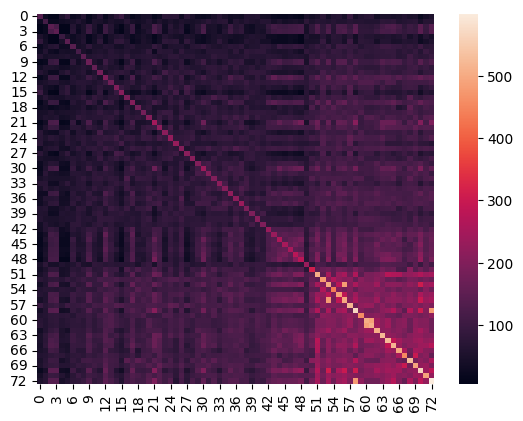

100%|██████████| 73/73 [00:00<00:00, 266.98it/s]


In [13]:
from tqdm import tqdm
r=substitution_matrices.read(open('sub.mat','r'))
aligner = PairwiseAligner(mode='local',alphabet=r.alphabet,substitution_matrix=r)
o=np.zeros((len(pcs_opt_df),len(pcs_opt_df)))
for i in tqdm(pcs_opt_df.index):
    for j in pcs_opt_df.index:
        o[i][j]=aligner.score(pcs_opt_df['mu-pred'][i],pcs_opt_df['mu-pred'][j])
        # o[i][j]=aligner.score(pcs_opt_df['mu-pred'][i],pcs_opt_df['mu-pred'][j])/((len(pcs_opt_df['mu'][i])**0.5)*(len(pcs_opt_df['mu'][j])**0.5))
# _=sns.clustermap(o)
o_pred_unnorm=o
sns.heatmap(o)
# plt.savefig('train/50palm/test_output/mu-pred-alignscore-origin.png')
plt.show()
plt.close()
# sns.heatmap(o)
# plt.savefig('train/50palm/test_output/mu-pred-alignscore-norm.png')
# plt.close()
# sns.clustermap(o)
# plt.savefig('train/50palm/test_output/mu-pred-alignscore-norm-cluster.png')
# plt.close()
o=np.zeros((len(pcs_opt_df),len(pcs_opt_df)))
for i in tqdm(pcs_opt_df.index):
    for j in pcs_opt_df.index:
        # o[i][j]=aligner.score(pcs_opt_df['mu-pred'][i],pcs_opt_df['mu-pred'][j])
        o[i][j]=aligner.score(pcs_opt_df['mu-pred'][i],pcs_opt_df['mu-pred'][j])/((len(pcs_opt_df['mu'][i])**0.5)*(len(pcs_opt_df['mu'][j])**0.5))
# _=sns.clustermap(o)
o_pred=o

100%|██████████| 73/73 [00:00<00:00, 317.54it/s]


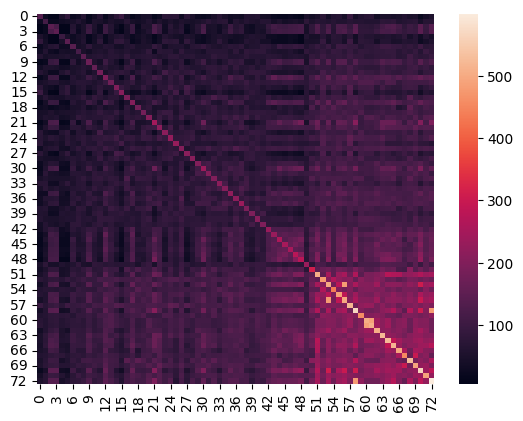

100%|██████████| 73/73 [00:00<00:00, 271.83it/s]


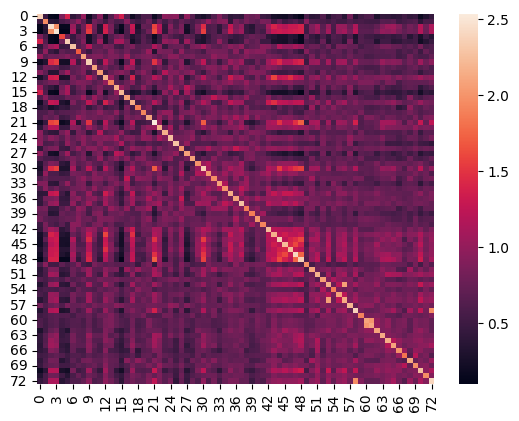

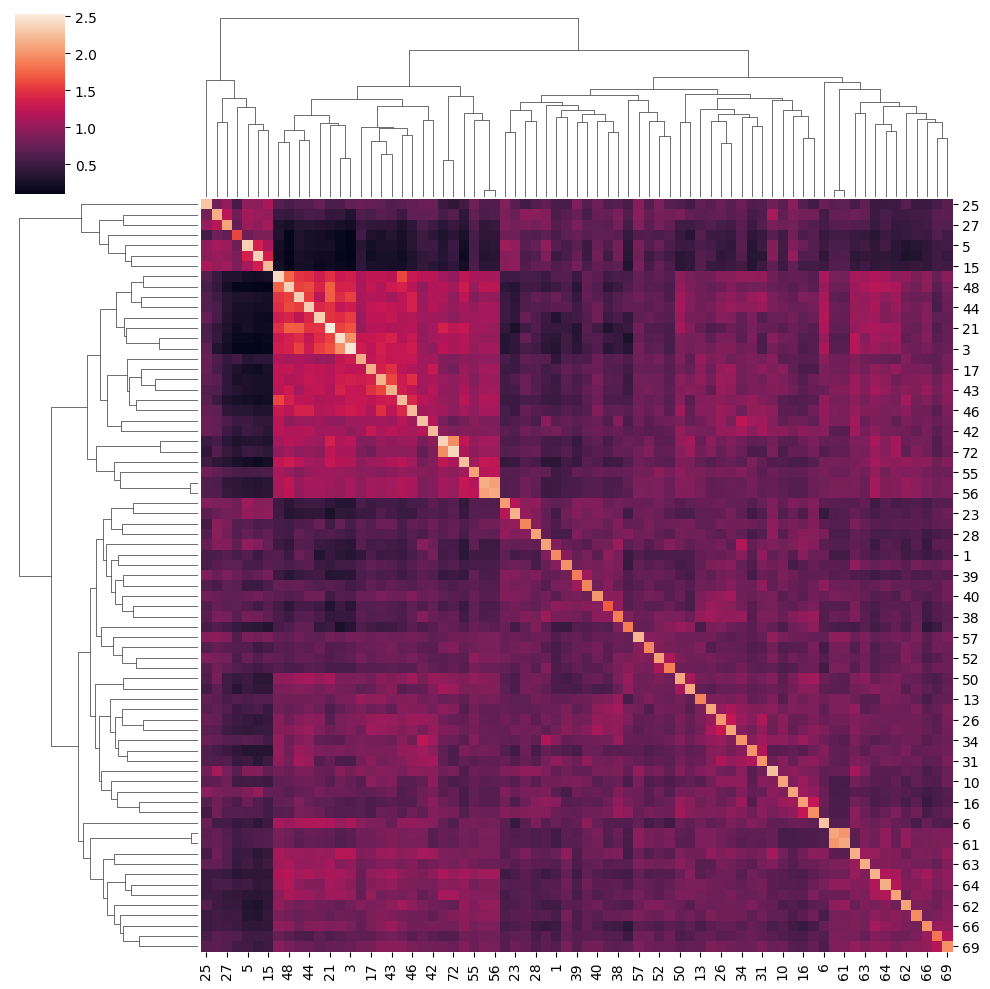

In [20]:

sns.heatmap(o)
plt.close()
# plt.savefig('train/50palm/test_output/mu-pred-alignscore-origin.png')
# plt.close()
sns.heatmap(o)
# plt.savefig('train/50palm/test_output/mu-pred-alignscore-norm.png')
plt.show()
plt.close()
sns.clustermap(o)
# plt.savefig('train/50palm/test_output/mu-pred-alignscore-norm-cluster.png')
plt.show()
plt.close()

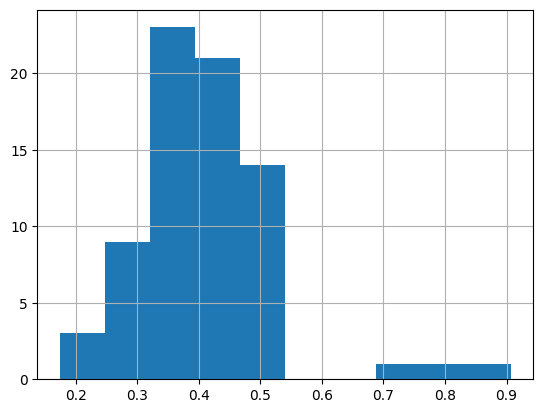

In [20]:
pcs_opt_df.apply(lambda x:aligner.score(x['mu-pred'],x['mu'])/aligner.score(x['mu'],x['mu']),axis=1).hist()
plt.show()
# aligner.score(pcs_opt_df['mu'][i],pcs_opt_df['mu-pred'][i])

100%|██████████| 73/73 [00:00<00:00, 266.29it/s]


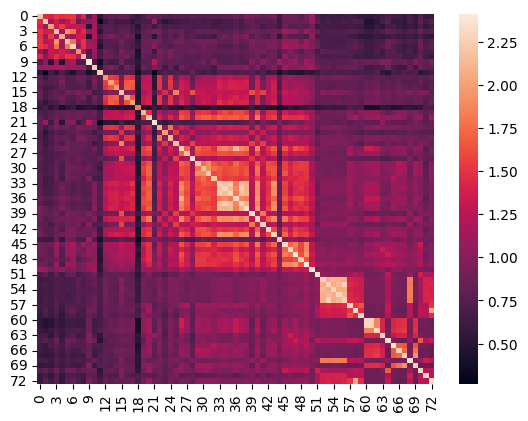

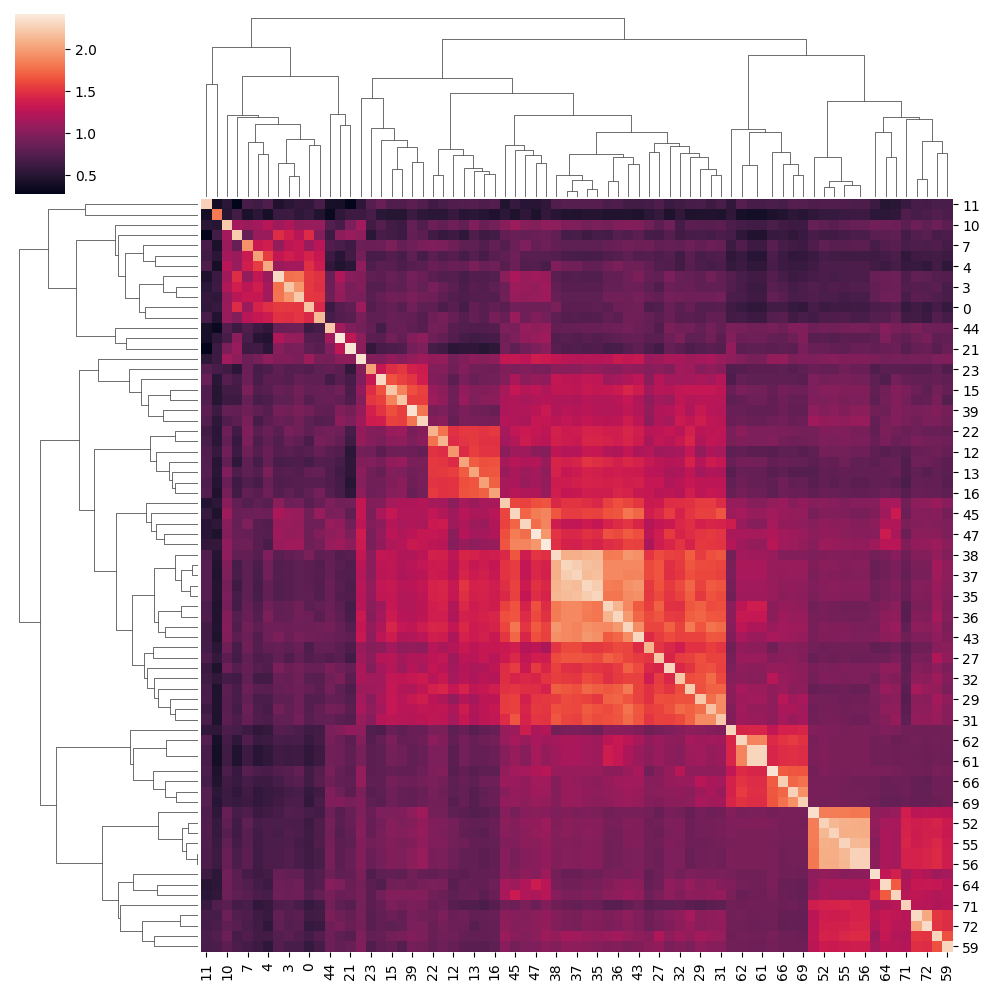

In [21]:
r=substitution_matrices.read(open('sub.mat','r'))
aligner = PairwiseAligner(mode='local',alphabet=r.alphabet,substitution_matrix=r)
o=np.zeros((len(pcs_opt_df),len(pcs_opt_df)))
for i in tqdm(pcs_opt_df.index):
    for j in pcs_opt_df.index:
        o[i][j]=aligner.score(pcs_opt_df['mu'][i],pcs_opt_df['mu'][j])
        # o[i][j]=aligner.score(pcs_opt_df['mu'][i],pcs_opt_df['mu'][j])/((len(pcs_opt_df['mu'][i])**0.5)*(len(pcs_opt_df['mu'][j])**0.5))
# _=sns.clustermap(o)
o_gt_unnorm=o
sns.heatmap(o)
plt.savefig('train/50palm/test_output/mu-esmfold-alignscore-origin.png')
plt.close()
# plt.savefig('train/50palm/test_output/mu-esmfold-alignscore-norm.png')
# plt.close()
# sns.clustermap(o)
# plt.savefig('train/50palm/test_output/mu-esmfold-alignscore-norm-cluster.png')
# plt.close()
o=np.zeros((len(pcs_opt_df),len(pcs_opt_df)))
for i in tqdm(pcs_opt_df.index):
    for j in pcs_opt_df.index:
        # o[i][j]=aligner.score(pcs_opt_df['mu'][i],pcs_opt_df['mu'][j])
        o[i][j]=aligner.score(pcs_opt_df['mu'][i],pcs_opt_df['mu'][j])/((len(pcs_opt_df['mu'][i])**0.5)*(len(pcs_opt_df['mu'][j])**0.5))
# _=sns.clustermap(o)
o_gt=o
sns.heatmap(o)
# plt.savefig('train/50palm/test_output/mu-esmfold-alignscore-origin.png')
# plt.close()
# plt.savefig('train/50palm/test_output/mu-esmfold-alignscore-norm.png')
plt.show()
plt.close()
sns.clustermap(o)
# plt.savefig('train/50palm/test_output/mu-esmfold-alignscore-norm-cluster.png')
plt.show()
plt.close()

In [22]:
aligner.score(pcs_opt_df['mu'][i],pcs_opt_df['mu'][j])

582.0

In [23]:
from scipy.stats import pearsonr,spearmanr
print(spearmanr(o_gt.reshape(-1),o_pred.reshape(-1)))
# plt.scatter(o_gt.reshape(-1),o_pred.reshape(-1))

SignificanceResult(statistic=0.31880210664059955, pvalue=3.6001003446778965e-126)


In [173]:
pcs_opt_df.loc[[15,4,0,5]]['stem']

15    u160513
4     u151861
0     u154044
5     u124479
Name: stem, dtype: object

In [48]:
aligner = PairwiseAligner(mode='global',alphabet=r.alphabet,substitution_matrix=r)
aln01=aligner.align(pcs_opt_df['mu'][71],pcs_opt_df['mu'][70])
print(aln01.score)
print(aln01[0],file=open('demo-align.txt','w'))

309.0


In [210]:
aligner = PairwiseAligner(mode='global',alphabet=r.alphabet,substitution_matrix=r)
aln01=aligner.align(pcs_opt_df['mu-pred'][71],pcs_opt_df['mu-pred'][70])
print(aln01.score)
print(aln01[0])

235.0
target            0 RRRRR-------------------------------PP----PPPPRR-----------j
                  0 ------------------------------------..----....-------------.
query             0 -----LLLLLLLLLLLLLdbbbbbbbbbbdddUTLLJJULLLJJJJ--JJJJJJSSbbbd

target           14 jjjjddddjjjjjjjdhhbbhhhjhhbhjjjjjjajjjjjdd-djjjja---RRRIPPPG
                 60 ....||||..-----|..||...-..|.------------..-|--------||--||.-
query            53 dddddddddd-----dbbbbbbb-bbbb------------bbbd-----bbbRR--PPJ-

target           70 PPAJPJJLLRRRRRRRPLJPAJPPRRRRRaaaaQZRa--------j----jaRRR-CCC-
                120 ||||-||---------|-|.-|||---------------------.----|.----..--
query            87 PPAJ-JJ---------P-JJ-JPP-------------JPYSbbbbdddddjU---ULL-J

target          116 -A---GPJ-PRRRRPPY--aja--a-jajdU-Uddd---bb--SJS-------------J
                180 -|---..|-.----..---||.--.-...|.-||||---||--|-|-------------|
query           118 JAJJJAJJAJ----JJ-JLajjddUUdUddddUddddddbbbbS-SbbbbbbbddddUUJ

target          14

In [95]:
gt_72='''VELDFSRFDRSLSVDLLKATEHYIYQIVFPPKIAGIRHSAIQLARMIGPIDAPQDFSEWVAKYDAVRREQITNALDLPES
ERVEYFQKIEQLDEVKDPRAIQARCDNFKARIGPWIAALEHRVRERLPFLVKGLDEPAKAAKINTLRRRALKVVELDFSR
FDRSLSVDLLKATEHYIYQIVFPPKIAGILSRQLHNTVSSRNGATYFVDGTRMSGDMNTSIGNCLIVACLMLAVGMPLDS
FVAEGDDMLA'''.replace('\n','')
aln01=aligner.align(gt_72,pcs_opt_df['mu-pred'][72])

In [194]:
aln01=aligner.align(pcs_opt_df['mu'][0],pcs_opt_df['mu'][1])
aln01.__dict__

{'sequences': ['RRQQRPRRQQKKLaaQRLRRUUUbbSSSVJYeeeehhhhhhjjaKKKKKKLJLLKLL',
  'RRLLLLLLLLLLLdddddhhbbhhbhhhhheeeeehhhhhhjjaKKKKKKLJLLKLL'],
 'score': 83.0,
 '_paths': <Path generator at 0x742df3ff32d0>,
 '_index': -1}

In [192]:
aln01=aligner.align(pcs_opt_df['mu-pred'][0],pcs_opt_df['mu-pred'][1])
aln01.__dict__

{'sequences': ['RRQQRPRRQQNNNfffjgggffWNNOXaXOOONNNNWfjjhjjjQNNNNNNOOOORO',
  'RRRRRPRRRRRRRjjjjjjehjjjjhhVVVMMVPMVhhhhhjjjKKKKKLRLLLLLR'],
 'score': 28.0,
 '_paths': <Path generator at 0x742df3bce7e0>,
 '_index': -1}

In [195]:
print(aln01[0])

target            0 RRQQRPRRQQKKLaaQRLRRUUU-----------bb--SSS-----VJYeeeehhhhhhj
                  0 ||--------..|----|--...-----------||--.-------.--|||||||||||
query             0 RR--------LLL----L--LLLLLLLdddddhhbbhhb--hhhhhe--eeeehhhhhhj

target           42 jaKKKKKKLJLLKLL 57
                 60 ||||||||||||||| 75
query            42 jaKKKKKKLJLLKLL 57



In [18]:
fs_opt=pd.read_csv('train/50palm/fsopt/esm_esm.opt',sep=r'\s+',header=None)
fs_opt.columns='query,target,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits'.split(',')
stem_id_map={k:i for i,k in enumerate(pcs_opt_df['stem'])}

In [17]:
o=np.zeros((len(pcs_opt_df),len(pcs_opt_df)))
for _,s in fs_opt.iterrows():
    o[stem_id_map[s['query']]][stem_id_map[s['target']]]=s['bits']
o=(o+o.T)/2
o_fs=o

In [24]:
from scipy.stats import pearsonr,spearmanr
print('spearmanr,fold,unnorm',spearmanr(o_gt_unnorm.reshape(-1),o_fs.reshape(-1)).statistic)
print('spearmanr,pred,unnorm',spearmanr(o_pred_unnorm.reshape(-1),o_fs.reshape(-1)).statistic)
print('spearmanr,fold,norm',spearmanr(o_gt.reshape(-1),o_fs.reshape(-1)).statistic)
print('spearmanr,pred,norm',spearmanr(o_pred.reshape(-1),o_fs.reshape(-1)).statistic)

spearmanr,fold,unnorm 0.6797395737710171
spearmanr,pred,unnorm 0.36999020852277853
spearmanr,fold,norm 0.7002129074522543
spearmanr,pred,norm 0.2706968144640906


In [36]:
print('pearsonr,fold&fs,unnorm',pearsonr(o_gt_unnorm.reshape(-1),o_fs.reshape(-1)).statistic)
print('pearsonr,pred&fs,unnorm',pearsonr(o_pred_unnorm.reshape(-1),o_fs.reshape(-1)).statistic)
print('pearsonr,pred&fold,unnorm',pearsonr(o_pred_unnorm.reshape(-1),o_gt_unnorm.reshape(-1)).statistic)


pearsonr,fold&fs,unnorm 0.7357724389096021
pearsonr,pred&fs,unnorm 0.5966613669341408
pearsonr,pred&fold,unnorm 0.8075829530695601


In [34]:
print('pearsonr,fold,norm',pearsonr(o_pred.reshape(-1),o_gt.reshape(-1)).statistic)
print('pearsonr,pred,norm',pearsonr(o_pred.reshape(-1),o_fs.reshape(-1)).statistic)
print('pearsonr,pred,norm',pearsonr(o_gt.reshape(-1),o_fs.reshape(-1)).statistic)


pearsonr,fold,norm 0.4454108861923579
pearsonr,pred,norm 0.47418266823181177
pearsonr,pred,norm 0.6834153374254828


In [32]:
# plt.scatter(o_gt_unnorm.reshape(-1),o_fs.reshape(-1))
bitscore_df=pd.DataFrame()
bitscore_df['foldseek']=o_fs.reshape(-1)
bitscore_df['mu-groundtruth']=o_gt_unnorm.reshape(-1)
bitscore_df['mu-predicted']=o_pred_unnorm.reshape(-1)

# plt.rcParams[] = 'none'
# plt.rcParams[] = True
sns.pairplot(bitscore_df,plot_kws=dict(linewidth=0,alpha=0.2,size=0.5,color='#a3a3a3'),diag_kws=dict(color='#a3a3a3',bins=30))
# plt.show()
f=plt.gcf()
f.set_dpi(1200)
f.savefig('/home/mutest1/SS4/ss4_sandbox/bitscore-comparison.svg')
f.savefig('/home/mutest1/SS4/ss4_sandbox/bitscore-comparison.png')
plt.close()

In [66]:
scores=pd.DataFrame()
scores['foldseek-gt']=o_fs.reshape(-1)
scores['fold-origin']=o_gt_unnorm.reshape(-1)
scores['fold-norm']=o_gt.reshape(-1)
scores['pred-origin']=o_pred_unnorm.reshape(-1)
scores['pred-norm']=o_pred.reshape(-1)

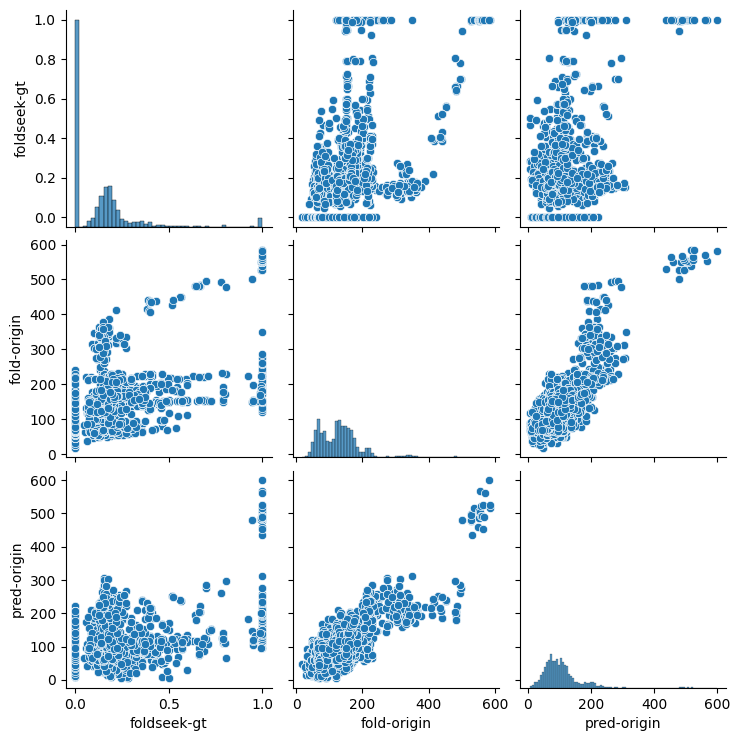

In [72]:
sns.pairplot(scores[['foldseek-gt','fold-origin','pred-origin']])

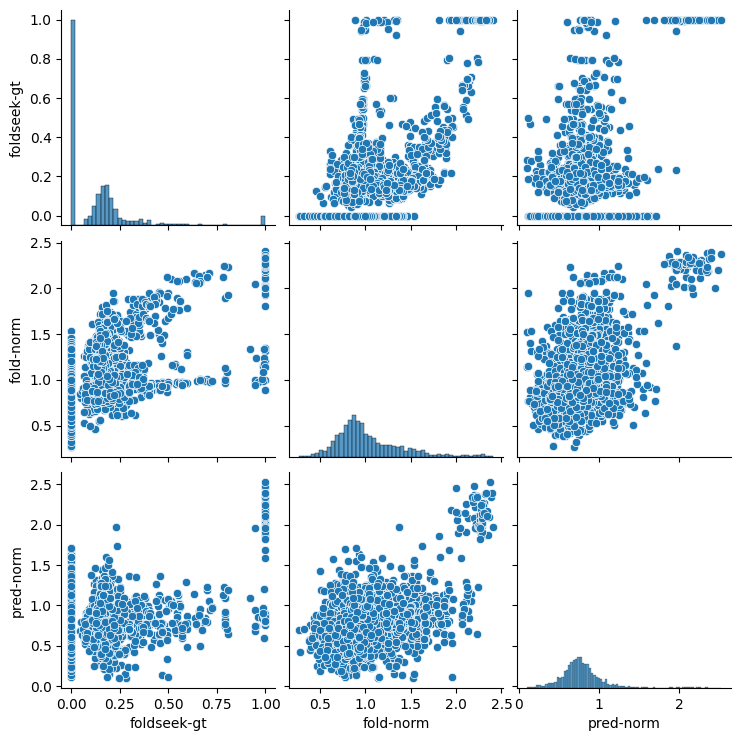

In [73]:
sns.pairplot(scores[['foldseek-gt','fold-norm','pred-norm']])


In [235]:
sns.heatmap(o)
plt.savefig('train/50palm/test_output/foldseek-fident.png')
plt.close()
sns.clustermap(o)
plt.savefig('train/50palm/test_output/foldseek-fident-cluster.png')
plt.close()

In [75]:
_=sns.clustermap(o_fs)
plt.close()
_.__dict__.keys()

dict_keys(['data', 'data2d', 'mask', '_figure', 'row_colors', 'row_color_labels', 'col_colors', 'col_color_labels', 'gs', 'ax_row_dendrogram', 'ax_col_dendrogram', 'ax_row_colors', 'ax_col_colors', 'ax_heatmap', 'ax_cbar', 'cax', 'cbar_pos', 'dendrogram_row', 'dendrogram_col'])

In [77]:
_.data2d.columns

Index([20, 58, 72, 40, 36, 62, 26, 60, 61, 68, 52, 54, 55, 53, 56, 34, 37, 33,
       35, 38, 43,  1, 11,  9, 44, 18, 21,  8,  5,  3,  6, 10,  4,  0,  2, 19,
       59, 27, 57, 32, 65, 29, 66, 31, 69, 30, 67, 48, 71, 47, 64, 42, 51, 49,
       45, 70,  7, 46, 63, 50, 22, 24, 12, 13, 17, 14, 16, 23, 28, 39, 41, 15,
       25],
      dtype='int64')

In [79]:
pcs_opt_df.loc[[1, 11,  9, 44, 18, 21]]['stem']

1     u156593
11    u100466
9      u35474
44     u33719
18     u32636
21     u34808
Name: stem, dtype: object

<Axes: >

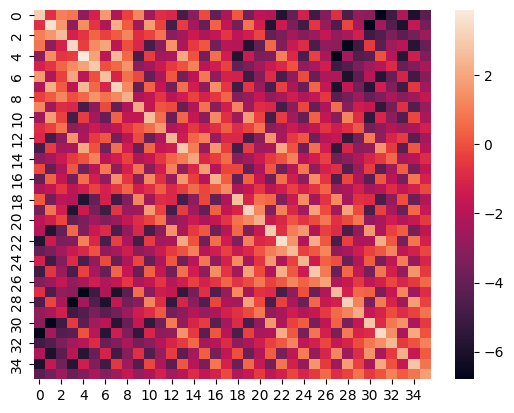

In [181]:
sns.heatmap(ScoreMx_Combo)

<Axes: >

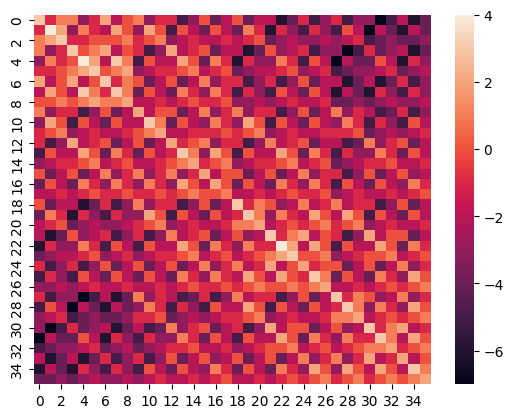

In [182]:
sns.heatmap(IntScoreMx_Combo)